<a href="https://colab.research.google.com/github/tangani/New-York-City-Taxi-Fare-Prediction/blob/main/new_york_city_taxi_fare_prediction_with_tensorflow_using_deep_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Fare Prediction using Deep Neural Networks

### Aim: Predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

**Import the needed dependencies :**

In [22]:
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import seaborn as sns

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [3]:
# Check for GPU availability

import tensorflow as tf
print('GPU','available(✔)' if tf.config.list_physical_devices("GPU") else "not available 😢")

GPU available(✔)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get the data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/train.csv', nrows=100000)
test_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/test.csv')

In [6]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [7]:
test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [8]:
longitude_nulls = len(train_df[train_df['dropoff_longitude'].isnull()])
latitude_nulls = len(train_df[train_df['dropoff_latitude'].isnull()])
print("There are {} dropoff_longitude values and {} dropoff_latitude values".format(longitude_nulls, latitude_nulls))

There are 0 dropoff_longitude values and 0 dropoff_latitude values


## Data Engineering steps:

Issues that affect taxi fares according to investopedia are as follows:
***
* Yellow cabs have regulated fares to and from the Newark International and John F. Kennedy International airports. For trips between Newark International Airport and New York City, the price is the regular metered fare, plus tolls. For trips between John F. Kennedy International Airport and Manhattan, it is a flat fare. The regular metered fare applies to all trips to and from LaGuardia International Airport.
***
1. Calculate the [Manhattan distance](https://www.sciencedirect.com/topics/computer-science/manhattan-distance) between pick up and drop off points. this is mainly because the Euclidean distance only looks for the shortest path etween two points where as the Manhattan distance was engineered specifically for the grid system like the one at hand.
2. Calculate the distance from each airports for either departure or arrival.
  1. [Newark International Airport](https://www.google.com/maps?client=firefox-b-d&sxsrf=ALeKk00u4W85sTWaeqEF2sopZPLeT8pW4A:1610458245182&q=newark+international+coordinates&gs_lcp=CgZwc3ktYWIQAxgAMgUIIRCgATIFCCEQoAE6BAgAEEc6EAguEMcBEK8BEMkDEEMQkwI6BAgAEEM6AggAOggILhDHARCvAToFCAAQyQM6BggAEBYQHjoHCCEQChCgAToECCEQFVCu0gJY4O0CYL31AmgAcAJ4AIABkQOIAZoVkgEHMi02LjIuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&um=1&ie=UTF-8&sa=X&ved=2ahUKEwiT-L_UwJbuAhXbiVwKHfxiCAAQ_AUoAXoECAgQAw) 40.6895° N, 74.1745° W
  2. [John F. Kennedy International Airport](https://www.google.com/maps?client=firefox-b-d&sxsrf=ALeKk03Lebh9DX88OXUBXYG3qP3KLMajbg:1610458294397&q=John+F.+Kennedy+International+coordinates&gs_lcp=CgZwc3ktYWIQAzoECAAQR1DU4ApY1OAKYP_nCmgAcAJ4AIAB6QOIAekDkgEDNC0xmAEAoAECoAEBqgEHZ3dzLXdpesgBCMABAQ&uact=5&um=1&ie=UTF-8&sa=X&ved=2ahUKEwiumfrJwZbuAhXDiFwKHR-uB2sQ_AUoAXoECBoQAw) 40.6413° N, 73.7781° W
3. Decompose `pickup_datetime` into its year, month, date and hour components. Futher extract the date of the week

In [9]:
def manhattan_vector(df):
  df['logitude_difference'] = (df.dropoff_longitude - df.pickup_longitude).abs()
  df['lottitude_difference'] = (df.dropoff_latitude - df.pickup_latitude).abs()

manhattan_vector(train_df)
manhattan_vector(test_df)

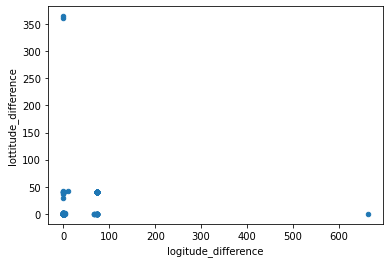

In [10]:
train_df.plot.scatter('logitude_difference', 'lottitude_difference')

### [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) will be used to calculate the distance from each airport.

For more details on the algoritm [click me](https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python) 

In [11]:
R = 6373.0

lat1 =np.asarray(np.radians(train_df['pickup_latitude']))
lon1 = np.asarray(np.radians(train_df['pickup_longitude']))
lat2 = np.asarray(np.radians(train_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(train_df['dropoff_longitude']))

lat3=np.zeros(len(train_df))+np.radians(40.6413111)
lon3=np.zeros(len(train_df))+np.radians(-73.7781391)

dlon_pickup = lon3 - lon1
dlat_pickup = lat3 - lat1

d_lon_dropoff=lon3 -lon2
d_lat_dropoff=lat3-lat2

a1 = np.sin(dlat_pickup/2)**2 + np.cos(lat1) * np.cos(lat3) * np.sin(dlon_pickup/ 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
distance1 = R * c1
train_df['Pickup_Distance_airport']=np.asarray(distance1)

a2=np.sin(d_lat_dropoff/2)**2 + np.cos(lat2) * np.cos(lat3) * np.sin(d_lon_dropoff/ 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
distance2 = R * c2

    
train_df['Dropoff_Distance_airport']=np.asarray(distance2)

In [12]:
lat1 =np.asarray(np.radians(test_df['pickup_latitude']))
lon1 = np.asarray(np.radians(test_df['pickup_longitude']))
lat2 = np.asarray(np.radians(test_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(test_df['dropoff_longitude']))

lat3=np.zeros(len(test_df))+np.radians(40.6413111)
lon3=np.zeros(len(test_df))+np.radians(-73.7781391)

dlon_pickup = lon3 - lon1
dlat_pickup = lat3 - lat1
d_lon_dropoff=lon3 -lon2
d_lat_dropoff=lat3-lat2
a1 = np.sin(dlat_pickup/2)**2 + np.cos(lat1) * np.cos(lat3) * np.sin(dlon_pickup/ 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
distance1 = R * c1
test_df['Pickup_Distance_airport']=np.asarray(distance1)*0.621

a2=np.sin(d_lat_dropoff/2)**2 + np.cos(lat2) * np.cos(lat3) * np.sin(d_lon_dropoff/ 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
distance2 = R * c2

    
test_df['Dropoff_Distance_airport']=np.asarray(distance2)*0.621

#### Fixing the pickup_datetime

In [13]:
train_df.pickup_datetime = train_df.pickup_datetime.str.slice(0,16)
test_df.pickup_datetime = test_df.pickup_datetime.str.slice(0,16)

In [14]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime, format='%Y-%m-%d %H:%M')
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime, format='%Y-%m-%d %H:%M')

In [15]:
def date_extractor(df):
  df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
  df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
  df['day'] = pd.DatetimeIndex(df['pickup_datetime']).day
  df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
  df['date'] = pd.DatetimeIndex(df['pickup_datetime']).date

date_extractor(train_df)
date_extractor(test_df)

In [16]:
def extract_weedkay(df):
  df['weekday'] = pd.to_datetime(df.pickup_datetime).dt.dayofweek

extract_weedkay(train_df)
extract_weedkay(test_df)

In [17]:
train_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                            value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)
test_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                              value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)

In [18]:
train_one_hot=pd.get_dummies(train_df['weekday'])
test_one_hot=pd.get_dummies(test_df['weekday'])
train_df=pd.concat([train_df,train_one_hot],axis=1)
test_df=pd.concat([test_df,test_one_hot],axis=1)

In [19]:
train_df.drop(['weekday', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'date'], axis=1, inplace=True)
test_df.drop(['weekday', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'date'], axis=1, inplace=True)

In [20]:
train_df.head()

,key,fare_amount,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-06-15 17:26:21.0000001,4.5,1,0.002701,0.009041,10.504844,9.538175,2009,6,15,17,0,1,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,1,0.036780,0.070701,21.526406,23.075107,2010,1,5,16,0,0,0,0,0,1,0
2,2011-08-18 00:35:00.00000049,5.7,2,0.008504,0.010708,21.810508,21.694306,2011,8,18,0,0,0,0,0,1,0,0
3,2012-04-21 04:30:42.0000001,7.7,1,0.004437,0.024949,20.372659,22.195713,2012,4,21,4,0,0,1,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,1,0.011440,0.015754,21.334291,21.853756,2010,3,9,7,0,0,0,0,0,1,0


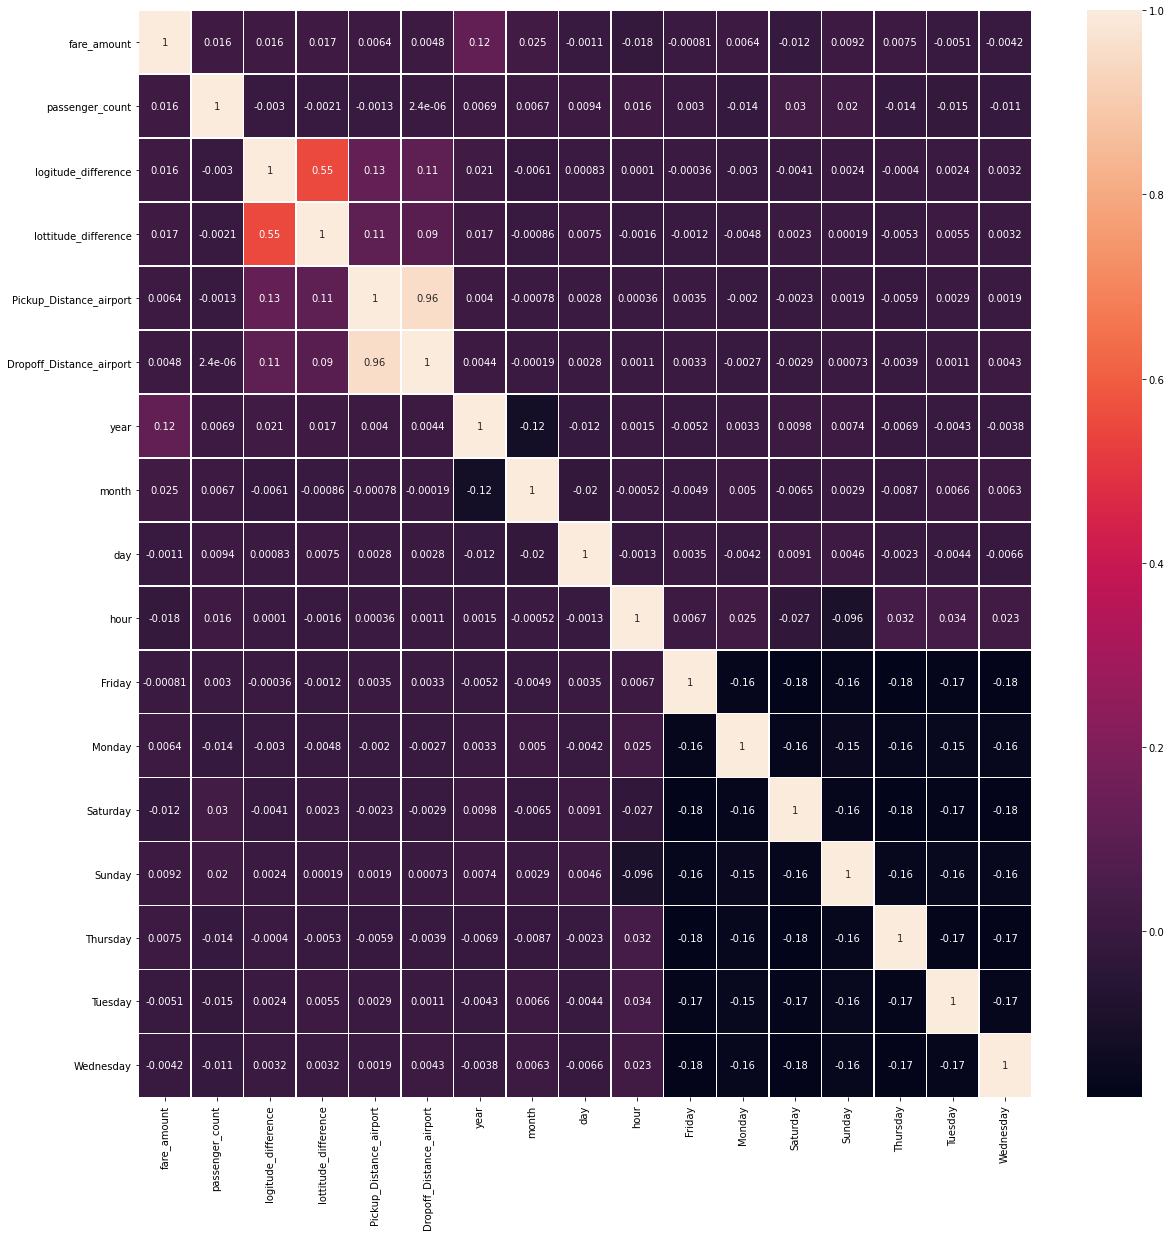

In [25]:
corr_matrix = train_df.corr()
plt.figure(figsize = (20,20))

sns.heatmap(corr_matrix,
            annot=True,
            linewidths=.5)

In [26]:
y = train_df['fare_amount']
train_df.drop(['key','fare_amount'], axis=1, inplace=True)

## Now into splitting and getting the data ready for model fitting

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2)

## Second : Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * Use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer

In [28]:
NN_model = Sequential()

**The Input Layer**

In [30]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

**The Hidden Layers**

In [31]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [32]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [33]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 167,041
Trainable params: 167,041
Non-trainable params: 0
_________________________________________________________________


**Define a checkpoint callback :**

In [34]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Third : Train the model :

In [38]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list) 

Epoch 1/500
2000/2000 [==============================] - 4s 2ms/step - loss: 5.4771 - mean_absolute_error: 5.4771 - val_loss: 5.3511 - val_mean_absolute_error: 5.3511

Epoch 00001: val_loss improved from inf to 5.35115, saving model to Weights-001--5.35115.hdf5
Epoch 2/500
2000/2000 [==============================] - 4s 2ms/step - loss: 5.4664 - mean_absolute_error: 5.4664 - val_loss: 5.3410 - val_mean_absolute_error: 5.3410

Epoch 00002: val_loss improved from 5.35115 to 5.34103, saving model to Weights-002--5.34103.hdf5
Epoch 3/500
2000/2000 [==============================] - 4s 2ms/step - loss: 5.4399 - mean_absolute_error: 5.4399 - val_loss: 5.3154 - val_mean_absolute_error: 5.3154

Epoch 00003: val_loss improved from 5.34103 to 5.31538, saving model to Weights-003--5.31538.hdf5
Epoch 4/500
2000/2000 [==============================] - 4s 2ms/step - loss: 5.3241 - mean_absolute_error: 5.3241 - val_loss: 4.7234 - val_mean_absolute_error: 4.7234

Epoch 00004: val_loss improved from 5.

In [41]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 167,041
Trainable params: 167,041
Non-trainable params: 0
_________________________________________________________________


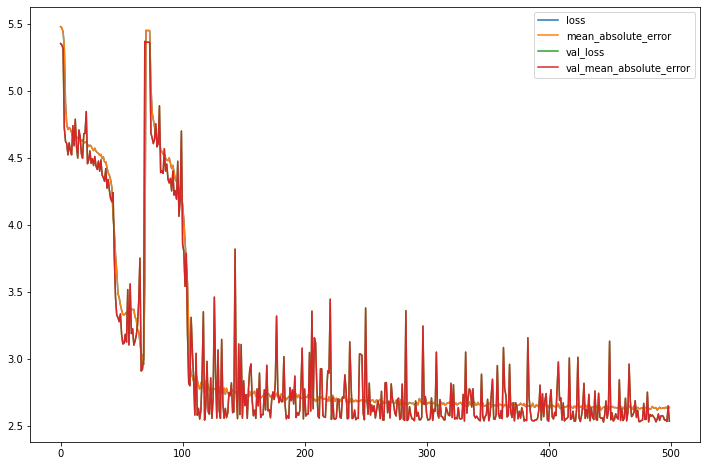

In [43]:
loss_df = pd.DataFrame(NN_model.history.history)
loss_df.plot(figsize=(12,8))

## Evaluation on Test Data

In [45]:
y_pred = NN_model.predict(X_test)

In [46]:
# evaluation metrics
# explained variance score: best possible score is 1 and lower values are worse
from sklearn import metrics

print('Mean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('Variance score is: {:.2f}'.format(metrics.explained_variance_score(y_test,y_pred)))

Mean Absolute Error: 2.53
Mean Squared Error: 29.17
Root Mean Squared Error: 5.40
Variance score is: 0.68


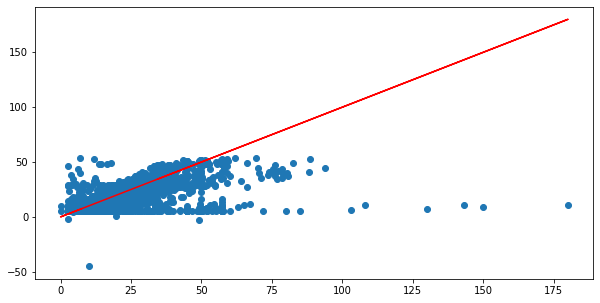

In [49]:
# Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

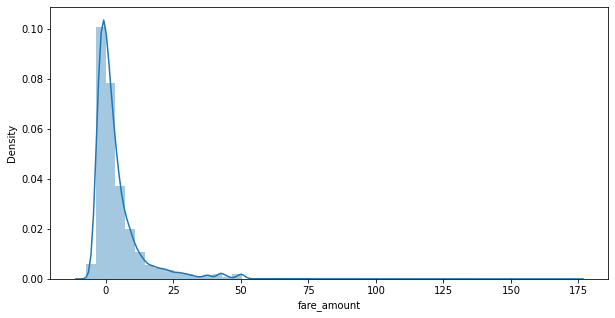

In [53]:
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred[0])
sns.distplot(residuals)